# Tema 25: Análisis de Varianza

El análisis de varianza es un caso especial de la regresión lineal que contesta la hipótesis alterna $ H_1: \exists\, i,j \in \{1, \dots, k\},\ i \ne j,\ \mu_i \ne \mu_j $, que se lee como: *existe un par i,j en los grupos de estudio para los que las medias de la variable dependiente son diferentes*.

:::{important}
Para esta libreta además de la librería `statsmodels`, utilizaremos `pingouin` una nueva librería que deberás instalar con `uv add pingouin` o `pip install pingouin` si no estás utilizando **uv**.

Considera que a diferencia de las demás librerías utilizadas hasta el momento, `pingouin` no está preinstalada en google colab, si estás trabajando en colab, corre lo siguiente en una celda de código:

```bash
!pip install -q pingouin
```

Hazlo antes de intentar importar la librería.
:::

## Librerías



In [16]:
import pandas as pd
import scipy.stats as stats
import statsmodels.api as sm
#!pip install -q pingouin # quita el comentario si estás en colab.
import pingouin as pg
import matplotlib.pyplot as plt
import seaborn as sns
print('Librerías importadas')

Librerías importadas


## Datos
Para esta libreta utilizaremos el dataset `palmer penguins` que trabajamos en la **Unidad 4**, pero esta vez lo cargaremos desde `pingouin`. 

Muchas librerías, tanto en `python` como en `R`, nos permiten importar bases de datos para probarlos. En las librerías que ya hemos utilizado, `seaborn` y `statsmodels` ofrecen muchos datos para probar, te sugiero que busques en su documentación. 

In [2]:
data = pg.read_dataset('penguins')
data.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Biscoe,37.8,18.3,174.0,3400.0,female
1,Adelie,Biscoe,37.7,18.7,180.0,3600.0,male
2,Adelie,Biscoe,35.9,19.2,189.0,3800.0,female
3,Adelie,Biscoe,38.2,18.1,185.0,3950.0,male
4,Adelie,Biscoe,38.8,17.2,180.0,3800.0,male


## Plan de análisis
Primero haremos un ANOVA de una vía, con la variable `body_mass_g` como dependiente y la variable `species` como factor de agrupación (independiente categórica).

Lo que queremos probar es lo siguiente:


$$
\exists\, i, j \in \{\text{Adelie}, \text{Chinstrap}, \text{Gentoo}\},\ i \ne j,\ \mu_i \ne \mu_j
$$

Es decir, existe un par de especies con media diferente para el peso.

Nuestro objetivo es probar la hipótesis nula:

$$
H_0: \mu_{Adelie} = \mu_{Chinstrap} = \mu_{Gentoo}
$$

## Statsmodels
Statsmodels implementa ANOVA como la extensión del modelo lineal, sin embargo, sus resultados son limitados y para obtener tamaños del efecto requeriríamos código adicional, por esto, `pingouin` trabaja a un mayor nivel programático, abstrayendo la tarea compleja. Primero veamos cómo generamos la tabla ANOVA con `statsmodels`

In [3]:
model_res = sm.OLS.from_formula(
    'body_mass_g ~ species', data
).fit()

table = sm.stats.anova_lm(model_res)
table

,df,sum_sq,mean_sq,F,PR(>F)
species,2.0,1.468642e+08,7.343211e+07,343.626275,2.892368e-82
Residual,339.0,7.244348e+07,2.136976e+05,NaN,NaN


Vemos que podemos rechazar la hipótesis nula, pero veamos cómo se ve este análisis con `pingouin`.

## Pingouin

Esta librería fue creada como una extensión alto nivel de `statsmodels` y `scipy` y está enfocada en tamaños del efecto para uso clínico, por lo que es ideal para su uso en ciencias de la salud.


In [4]:
pg.anova(
    data, # los datos
    dv='body_mass_g', # variable dependiente
    between='species', # variable de agrupación
    detailed=True, # información adicional
)

,Source,SS,DF,MS,F,p-unc,np2
0,species,1.468642e+08,2,7.343211e+07,343.626275,2.892368e-82,0.669672
1,Within,7.244348e+07,339,2.136976e+05,NaN,NaN,NaN


Podemos ver que con una sola función de fácil uso, logramos un resultado muy parecido pero con información adicional, muy importante `np2` corresponde a $\eta^2$, el tamaño del efecto. 

Esto lo intepretamos como que existe una diferencia significativa en el peso de los pingüinos de acuerdo a su especie, con un tamaño de efecto muy grande. Visualicémoslo.

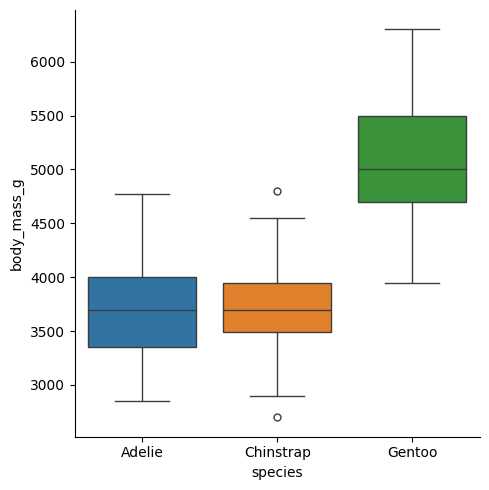

In [5]:
sns.catplot(
    data,
    x='species',
    y='body_mass_g',
    kind='box',
    hue='species', # agrega color
)

## Post-Hoc
Habiendo encontrado la diferencia, lo apropiado es correr una prueba post-hoc para encontrar los pares que difieren.

Pingouin ofrece esta herramienta con el código prácticamente idéntico que para el ANOVA.

In [6]:
pg.pairwise_tukey(
    data, # los datos
    dv='body_mass_g', # variable dependiente
    between='species', # variable de agrupación
)

,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,Adelie,Chinstrap,3700.662252,3733.088235,-32.425984,67.511684,-0.480302,0.880667,-0.073946
1,Adelie,Gentoo,3700.662252,5076.016260,-1375.354009,56.147971,-24.495169,0.000000,-2.860201
2,Chinstrap,Gentoo,3733.088235,5076.016260,-1342.928025,69.856928,-19.223978,0.000000,-2.875327


Corroboramos lo que el diagrama de caja y brazos sugería, existe una diferencia entre Gentoo y las otras dos especies, pero no entre Adelie y Chinstrap.

Observa además que tenemos el tamaño del efecto de hedge para cada par.

## ANOVA de dos vías

Repitamos el análisis pero ajustemos como agrupación adicional `sex`, para ver si el peso varía también entre sexos y si la especie puede interactuar con el sexo afectando el peso del pingüino.


In [7]:
pg.anova(
    data,
    dv='body_mass_g',
    between=['species', 'sex'], # pasamos list en lugar de str
    detailed=True,
)

,Source,SS,DF,MS,F,p-unc,np2
0,species,1.434016e+08,2.0,7.170079e+07,749.015666,8.144406e-123,0.820825
1,sex,3.709026e+07,1.0,3.709026e+07,387.459976,1.902273e-57,0.542312
2,species * sex,1.676557e+06,2.0,8.382784e+05,8.756997,1.973489e-04,0.050837
3,Residual,3.130263e+07,327.0,9.572669e+04,NaN,NaN,NaN


Corroboramos nuevamente nuestra hipótesis, existe dimorfismo sexual. Veamos el post-hoc the tukey para sexo.

In [8]:
pg.pairwise_tukey(
    data,
    dv='body_mass_g',
    between='sex',
)

,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,female,male,3862.272727,4545.684524,-683.411797,80.008683,-8.54172,1.612044e-13,-0.934082


Y para la interacción? Para esto debemos crear una nueva variable que combine los pares entre especie y sexo y meteremos cada una dentro de la prueba de tukey.

In [9]:
data['group'] = data['species'] + '-' + data['sex']

# Comparaciones post-hoc entre combinaciones especie-sexo
pg.pairwise_tukey(
    data=data,
    dv='body_mass_g',
    between='group'
)

,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,Adelie-female,Adelie-male,3368.835616,4043.493151,-674.657534,51.211806,-13.173867,0.000000e+00,-2.161343
1,Adelie-female,Chinstrap-female,3368.835616,3527.205882,-158.370266,64.240295,-2.465279,1.376213e-01,-0.572822
2,Adelie-female,Chinstrap-male,3368.835616,3938.970588,-570.134972,64.240295,-8.875037,0.000000e+00,-1.876696
3,Adelie-female,Gentoo-female,3368.835616,4679.741379,-1310.905763,54.422282,-24.087666,0.000000e+00,-4.741976
4,Adelie-female,Gentoo-male,3368.835616,5484.836066,-2116.000449,53.671357,-39.425134,0.000000e+00,-7.252527
5,Adelie-male,Chinstrap-female,4043.493151,3527.205882,516.287268,64.240295,8.036813,1.999512e-13,1.559300
6,Adelie-male,Chinstrap-male,4043.493151,3938.970588,104.522562,64.240295,1.627056,5.812048e-01,0.295064
7,Adelie-male,Gentoo-female,4043.493151,4679.741379,-636.248229,54.422282,-11.690951,0.000000e+00,-1.978960
8,Adelie-male,Gentoo-male,4043.493151,5484.836066,-1441.342915,53.671357,-26.854974,0.000000e+00,-4.317487
9,Chinstrap-female,Chinstrap-male,3527.205882,3938.970588,-411.764706,75.039869,-5.487279,1.219550e-06,-1.248653


Podemos ver un enorme efecto entre sexo y especie, sobre todo en los machos Gentoo, que son los más pesados.

## ANCOVA
Para terminar las demostraciones, ajustemos el modelo simple de nuestro ANOVA de una vía entre peso y especie para el tamaño del pico.


In [10]:
pg.ancova(
    data,
    dv='body_mass_g',
    between='species',
    covar=['bill_length_mm', 'bill_depth_mm']
)

,Source,SS,DF,F,p-unc,np2
0,species,7.828083e+07,2,349.264191,7.093167e-83,0.674562
1,bill_length_mm,6.633645e+06,1,59.194431,1.591048e-13,0.149408
2,bill_depth_mm,9.847683e+06,1,87.874461,1.044582e-18,0.206825
3,Residual,3.776602e+07,337,NaN,NaN,NaN


## Medidas repetidas
Analizaremos ahora el dataset `sleepstudy` que analizó a una serie de sujetos en el tiempo y cómo su tiempo de reacción se deteriora en el tiempo conforme se les depriva de sueño.

Este dataset se utiliza con mucha frecuencia en el contexto de modelos mixtos, también lo utilizaremos con ese fin más adelante en el curso, pero por ahora veamos cómo se ve el ANOVA de medidas repetidas

In [11]:
sleep_data = sm.datasets.get_rdataset('sleepstudy', package='lme4').data
sleep_data.head()

,Reaction,Days,Subject
0,249.5600,0,308
1,258.7047,1,308
2,250.8006,2,308
3,321.4398,3,308
4,356.8519,4,308


Visualicemos los cambios.

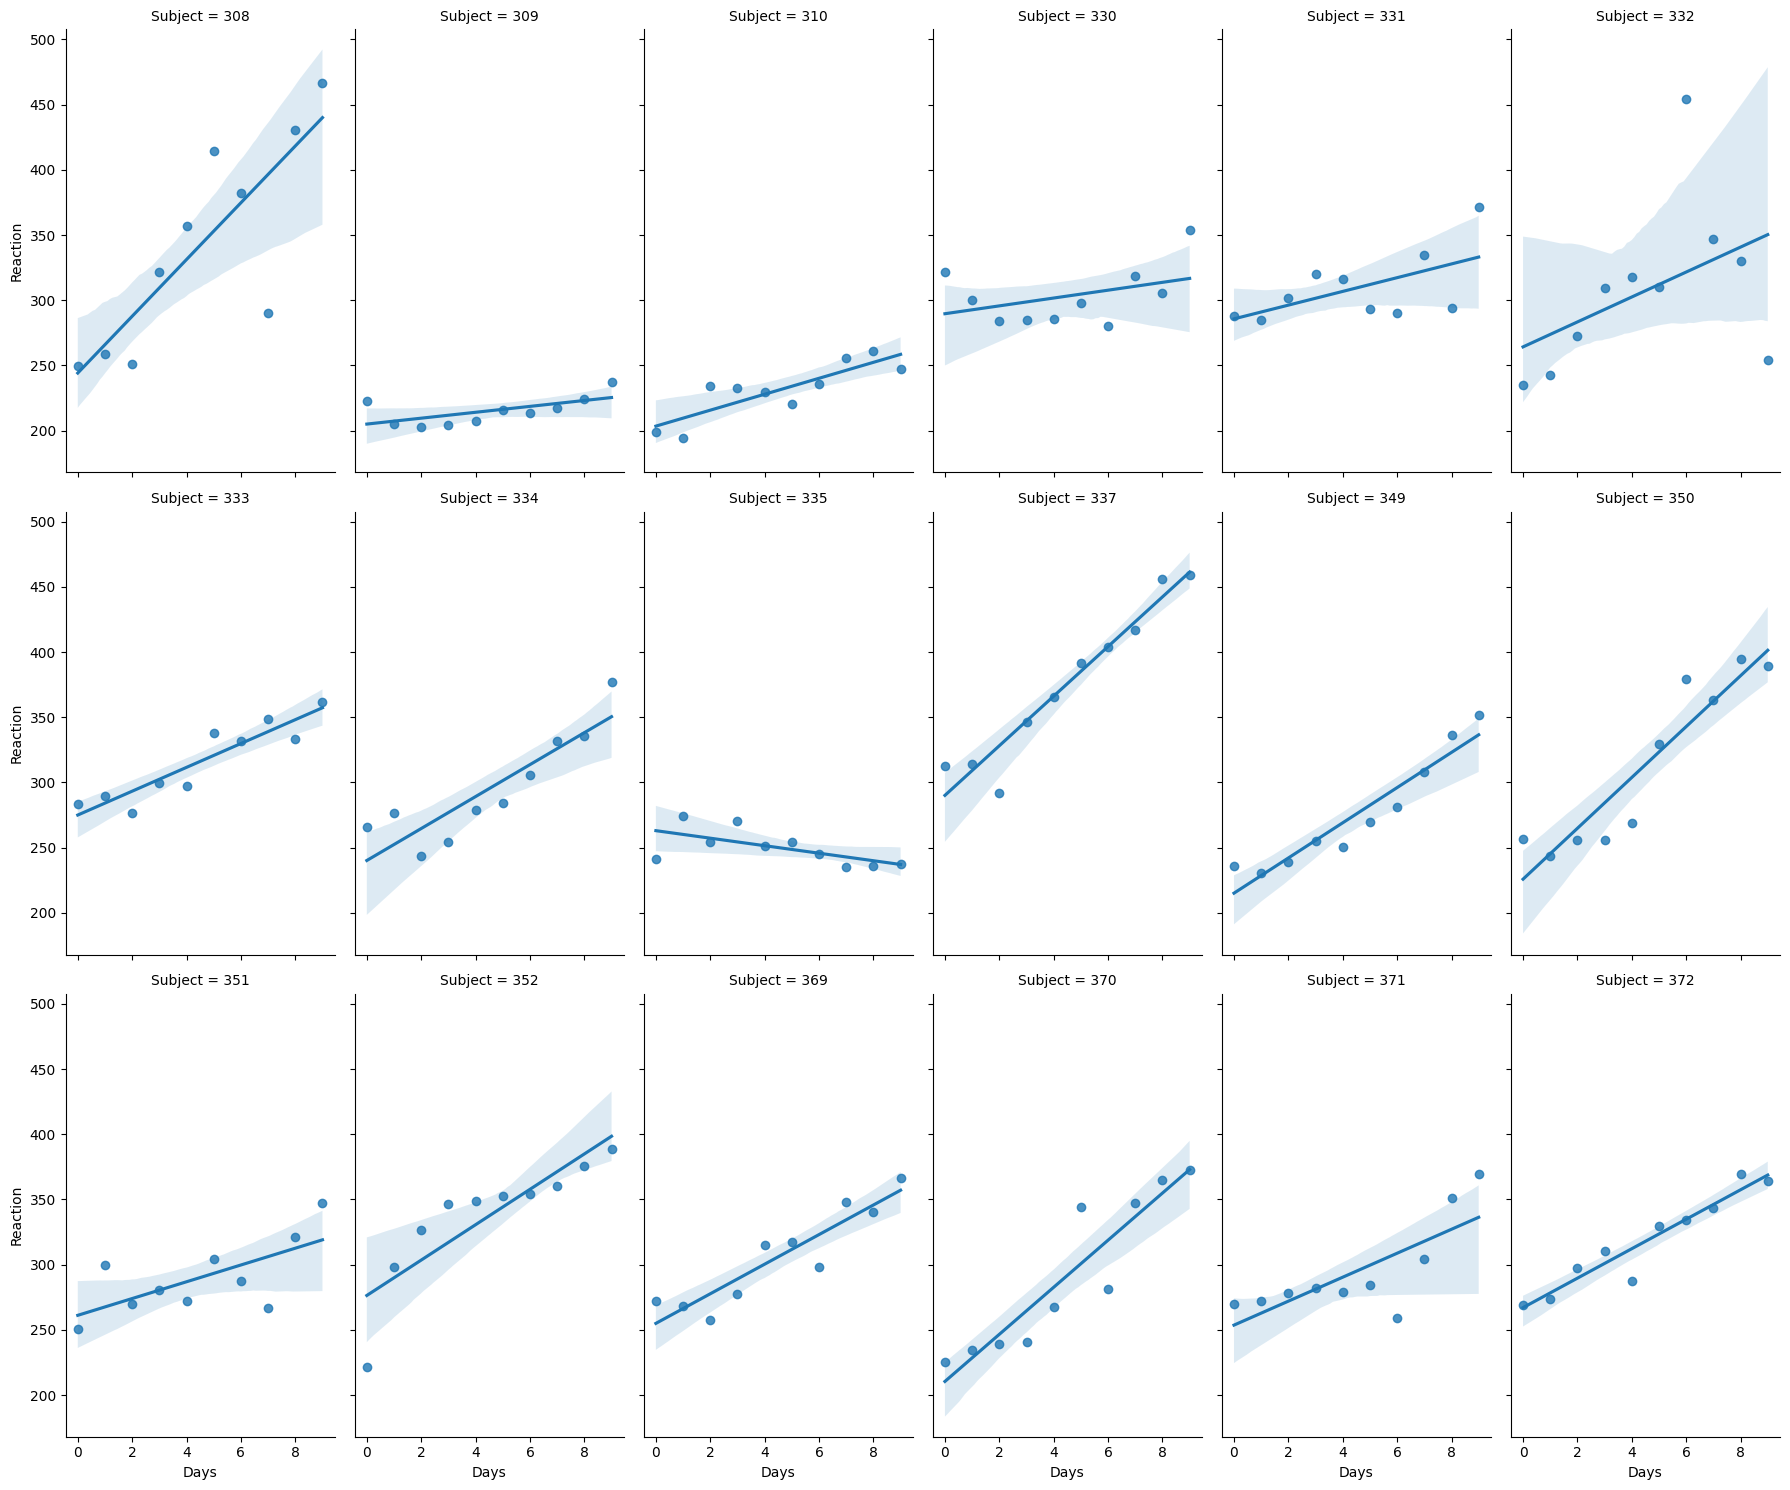

In [12]:
sns.lmplot(
    sleep_data,
    col='Subject',
    col_wrap=6,
    x='Days',
    y='Reaction',
    aspect=0.6,
)

Podemos ver que en general, se incrementa el tiempo de reacción conforme se depriva del sueño al sujeto, excepto para el sujeto 335 que se tomó muy serie el ejercicio.

Probemos ahora la hipótesis de que el tiempo de reacción no varía de acuerdo al número de días.

In [13]:
pg.rm_anova(
    sleep_data,
    dv='Reaction',
    within='Days',
    subject='Subject'
)

,Source,ddof1,ddof2,F,p-unc,p-GG-corr,ng2,eps,sphericity,W-spher,p-spher
0,Days,9,153,18.702698,8.995345e-21,5.463092e-09,0.292691,0.36903,False,0.000219,5.154879e-08


Podemos ver que el tiempo efectivamente varía en el tiempo para cada sujeto, con una p significativa, aún con la corrección por esfericidad (Greenhouse-Geisser). Por lo que corroboramos que existe un cambio significativo con un tamaño de efecto importante.

## No paramétrico

Veamos cómo analizar la diferencia entre más de dos grupos con las pruebas no paramétricas de Kruskal-Wallis y Friedman.

### Grupos independientes
Para analizar más de dos grupos en forma no paramétrica, la prueba de rutina es Kruskal-Wallis, que en python está implementada en varios paquetes.

#### Scipy

In [39]:
clean_data = data.dropna(subset=['species', 'body_mass_g'])
# esta es otra forma de extraer los grupos
# primero agrupamos y seleccionamos la columna
groups = clean_data.groupby('species')['body_mass_g']
# luego extraemos los grupos
adelie = groups.get_group('Adelie')
chinstrap = groups.get_group('Chinstrap')
gentoo = groups.get_group('Gentoo')

stats.kruskal(adelie, chinstrap, gentoo)

KruskalResult(statistic=np.float64(217.59924143680436), pvalue=np.float64(5.609512095829062e-48))

#### Pingouin

In [40]:
# la sintaxis es muy parecida al anova
pg.kruskal(data, dv='body_mass_g', between='species', detailed=True)


,Source,ddof1,H,p-unc
Kruskal,species,2,217.599241,5.609512e-48


### Medidas repetidas

Para el análisis de Friedman contamos con las mismas herramientas.

#### scipy
Como tenemos varios días en el estudio, necesitamos extraer cada día directamente a un objeto, en lugar de separar en variables como hicimos con las especies, lo haremos con los días.

In [43]:
dias = []

for name, group in sleep_data.groupby('Days')['Reaction']:
    print('guardando día:', name)
    dias.append(group)



guardando día: 0
guardando día: 1
guardando día: 2
guardando día: 3
guardando día: 4
guardando día: 5
guardando día: 6
guardando día: 7
guardando día: 8
guardando día: 9


Ahora en la variable `dias` tenemos una lista con los valores del tiempo de reacción para cada día, pongámoslo en la prueba de friedman.

In [44]:
stats.friedmanchisquare(*dias) 

FriedmanchisquareResult(statistic=np.float64(86.08484848484852), pvalue=np.float64(9.904181018793203e-15))

El operador `*` antes de la lista, "desempaqueta" la colección en los argumentos de la función. Si analizamos el encabezado de la función vemos esto `def friedmanchisquare(*samples: Any)`, puedes ver que samples es un argumento que puede recibir cualquier cantidad de valores y terminan todos en una lista, al utilizar `*dias` estamos pasando cada objeto dentro de la lista al parámetro `samples`. Revisa el tema de [argumentos](#parametros-variables-target) para recordar estos conceptos.

#### pingouin

In [ ]:
pg.friedman(
    sleep_data, dv='Reaction', within='Days', subject='Subject', 
)

,Source,W,ddof1,Q,p-unc
Friedman,Days,0.531388,9,86.084848,9.904181e-15


Nuevamente `pingouin` es más sencillo de utilizar y produce resultados más estéticos. 

## Ejercicios
1. Explora qué otros datasets están disponibles en las tres librerías `seaborn`, `statsmodels` y `pingouin`. Deberás revisar su documentación.
2. Utiliza `statsmodels` para ejecutar las pruebas post-hoc, `pingouin` lo hace muy fácil, ve si puedes descifrar cómo hacerlo sin esta herramienta.
3. Explora cómo cambiar los supuestos (por ejemplo, violación de esfericidad o heterocedasticidad) y cómo afectan los resultados del ANOVA.